In [20]:
main_path = '.'
nyc_data = main_path+str("/nyc_data.csv")
print(nyc_data)

./nyc_data.csv


In [21]:
# Libraries 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [22]:
# load the data (for prophete, the Date information must be part of the data and not an index as the project before.)
# YYYY-MM-DD
df = pd.read_csv(nyc_data)
future_df = pd.read_csv('future.csv')
future_df.tail() 

,Date,Demand,Easter,Thanksgiving,Christmas,Temperature,Marketing
26,1/27/2021,NaN,0,0,0,3.33,39.664
27,1/28/2021,NaN,0,0,0,1.67,195.314
28,1/29/2021,NaN,0,0,0,-2.78,235.894
29,1/30/2021,NaN,0,0,0,1.11,152.752
30,1/31/2021,NaN,0,0,0,4.44,158.620


In [23]:
# Merging the dataset 
# Be careful when just concating. The index may (most likely) not represent what you really have.  So you need to reset the index
# Without reseting the index, the dataframe goes until 30 indexes for this problem. 
# After reseting, it goes to 2220 (which is what we expect to have due to the number of data in the df)
df = pd.concat([df, future_df])
df = df.reset_index(drop=True)
df.tail()

,Date,Demand,Easter,Thanksgiving,Christmas,Temperature,Marketing
2218,1/27/2021,NaN,0,0,0,3.33,39.664
2219,1/28/2021,NaN,0,0,0,1.67,195.314
2220,1/29/2021,NaN,0,0,0,-2.78,235.894
2221,1/30/2021,NaN,0,0,0,1.11,152.752
2222,1/31/2021,NaN,0,0,0,4.44,158.620


In [24]:
# Rename variable 
# ds = date stamp
df = df.rename(columns={'Demand': 'y', 'Date':'ds'})
df.head(0)

,ds,y,Easter,Thanksgiving,Christmas,Temperature,Marketing


# Transforming the date variable

In [25]:
# YYYY-MM-DD (this is a standard format but also required for the prophet library)
df.ds = pd.to_datetime(df.ds, format="%m/%d/%Y")
df.head()

,ds,y,Easter,Thanksgiving,Christmas,Temperature,Marketing
0,2015-01-01,720.000885,0,0,0,3.68,41.305
1,2015-01-02,581.276773,0,0,0,4.73,131.574
2,2015-01-03,754.117039,0,0,0,7.23,162.700
3,2015-01-04,622.252774,0,0,0,10.96,160.281
4,2015-01-05,785.373319,0,0,0,6.92,51.077


# Holidays

In [26]:
# Easter Holiday
# Get all the Easter dates. 
# To do so, we extract from the DataTable when Easter == 1
# '.ds' means we only get the dates
dates = df[df.Easter == 1].ds

# we create a DataFrame, but also include the window parameter. It represents the days before and the days ahead of the event
# in our case, we do it by choosing '5 days' in advance and only '2 days' afterward

easter = pd.DataFrame({'holiday': 'easter', 'ds':dates, 'lower_window':-5, 'upper_window':2})
easter

,holiday,ds,lower_window,upper_window
94,easter,2015-04-05,-5,2
451,easter,2016-03-27,-5,2
836,easter,2017-04-16,-5,2
1186,easter,2018-04-01,-5,2
1571,easter,2019-04-21,-5,2
1928,easter,2020-04-12,-5,2


In [27]:
# Thanksgiving 
dates = df[df.Thanksgiving == 1].ds
thanksgiving = pd.DataFrame({'holiday': 'thanksgiving', 'ds':dates, 'lower_window':-3, 'upper_window':5})
thanksgiving

,holiday,ds,lower_window,upper_window
329,thanksgiving,2015-11-26,-3,5
693,thanksgiving,2016-11-24,-3,5
1057,thanksgiving,2017-11-23,-3,5
1421,thanksgiving,2018-11-22,-3,5
1792,thanksgiving,2019-11-28,-3,5
2156,thanksgiving,2020-11-26,-3,5


In [28]:
# Christmas 
dates = df[df.Thanksgiving == 1].ds
christmas = pd.DataFrame({'holiday': 'christmas', 'ds':dates, 'lower_window':-7, 'upper_window':7})
christmas

,holiday,ds,lower_window,upper_window
329,christmas,2015-11-26,-7,7
693,christmas,2016-11-24,-7,7
1057,christmas,2017-11-23,-7,7
1421,christmas,2018-11-22,-7,7
1792,christmas,2019-11-28,-7,7
2156,christmas,2020-11-26,-7,7


# Combine all events

In [29]:
# We need to store and merge everything 
holidays = pd.concat([easter, thanksgiving, christmas])
holidays.head()

,holiday,ds,lower_window,upper_window
94,easter,2015-04-05,-5,2
451,easter,2016-03-27,-5,2
836,easter,2017-04-16,-5,2
1186,easter,2018-04-01,-5,2
1571,easter,2019-04-21,-5,2


# Drop holidays from DataFrame

In [30]:
# Note that by dropping the holidays we have our regressors (temperature and marketing)
df_final = df.drop(columns=["Easter", "Thanksgiving", "Christmas"])
df_final.head()

,ds,y,Temperature,Marketing
0,2015-01-01,720.000885,3.68,41.305
1,2015-01-02,581.276773,4.73,131.574
2,2015-01-03,754.117039,7.23,162.700
3,2015-01-04,622.252774,10.96,160.281
4,2015-01-05,785.373319,6.92,51.077


# Prophet model

In [31]:
# Index col parameter is very important here because otherwise the index will be 0,1,2,...instead of the names we want to have later
parameters = pd.read_csv("prophete_best_params_forecasting_product.csv", index_col=0)
parameters

,0
changepoint_prior_scale,0.01
holidays_prior_scale,5
seasonality_mode,additive
seasonality_prior_scale,5
rmse,48.069


In [32]:
# Extracting the parameters
# ps: .loc["string"] return a object datatype. We need to convert it so we can use it lalter in our model
cps = float(parameters.loc["changepoint_prior_scale"]) # let's abreviate as cps 
hps = float(parameters.loc["holidays_prior_scale"])
sps = float(parameters.loc["seasonality_prior_scale"])
sm = parameters.loc["seasonality_mode"]
sm = sm[0]

/tmp/ipykernel_23260/1675101383.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  cps = float(parameters.loc["changepoint_prior_scale"]) # let's abreviate as cps
/tmp/ipykernel_23260/1675101383.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  hps = float(parameters.loc["holidays_prior_scale"])
/tmp/ipykernel_23260/1675101383.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sps = float(parameters.loc["seasonality_prior_scale"])
/tmp/ipykernel_23260/1675101383.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

In [33]:
# Splitting the data 
training  = df_final.iloc[:-31,:]
future_df = df_final.iloc[-31:,:]

In [34]:
from prophet import Prophet

In [35]:
# Building the model 
# It idedntifies the yearly,weakly and daily data automatically if the parameter is set to be 'auto' (default value)
m = Prophet(
    holidays=holidays,
    seasonality_mode= sm, 
    seasonality_prior_scale=sps, 
    holidays_prior_scale=hps, 
    changepoint_prior_scale=cps
    )

# Becacuse our df_final dataframe has the regressors, we need to add the following commands
m.add_regressor("Temperature")
m.add_regressor("Marketing")
m.fit(training)

00:06:23 - cmdstanpy - INFO - Chain [1] start processing
00:06:23 - cmdstanpy - INFO - Chain [1] done processing


# Forecasting 

In [36]:
# Make a future dataframe
# periods (how long in the future do we want to forecast ?)
# frequence (how is the frequency of these periods?) D=Day, M=Month, W=Week
future = m.make_future_dataframe(periods=len(future_df), freq="D")

# we need to have the stamps for both, for the past and future. 
# let's get everything startinf from index 2, i.e., df.iloc[:,2]
# pay attention: in this case we do not have things concatenated from top to bottom, insntead from left to right
# so the future dataframe becomes
future = pd.concat([future, df_final.iloc[:,2:]], axis=1)
future.head()

,ds,Temperature,Marketing
0,2015-01-01,3.68,41.305
1,2015-01-02,4.73,131.574
2,2015-01-03,7.23,162.700
3,2015-01-04,10.96,160.281
4,2015-01-05,6.92,51.077


In [37]:
# Forecasting 
forecasting = m.predict(future)
forecasting.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Marketing,Marketing_lower,Marketing_upper,Temperature,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01,595.897055,618.540249,761.216732,595.897055,595.897055,-3.416203,-3.416203,-3.416203,10.373281,...,-3.884294,-3.884294,-3.884294,90.325132,90.325132,90.325132,0.0,0.0,0.0,689.294971
1,2015-01-02,596.012618,535.476368,673.551444,596.012618,596.012618,0.196003,0.196003,0.196003,9.412170,...,-89.537506,-89.537506,-89.537506,89.149843,89.149843,89.149843,0.0,0.0,0.0,605.233127
2,2015-01-03,596.128180,646.409440,787.645306,596.128180,596.128180,1.441541,1.441541,1.441541,7.123809,...,25.714602,25.714602,25.714602,88.105644,88.105644,88.105644,0.0,0.0,0.0,718.513776
3,2015-01-04,596.243743,561.839035,707.111646,596.243743,596.243743,1.344743,1.344743,1.344743,3.709575,...,-55.467285,-55.467285,-55.467285,87.209507,87.209507,87.209507,0.0,0.0,0.0,633.040282
4,2015-01-05,596.359305,690.062324,831.731906,596.359305,596.359305,-3.025166,-3.025166,-3.025166,7.407566,...,74.127131,74.127131,74.127131,86.473976,86.473976,86.473976,0.0,0.0,0.0,761.342811


/home/renan/.python_env/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/renan/.python_env/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/home/renan/.python_env/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To ret

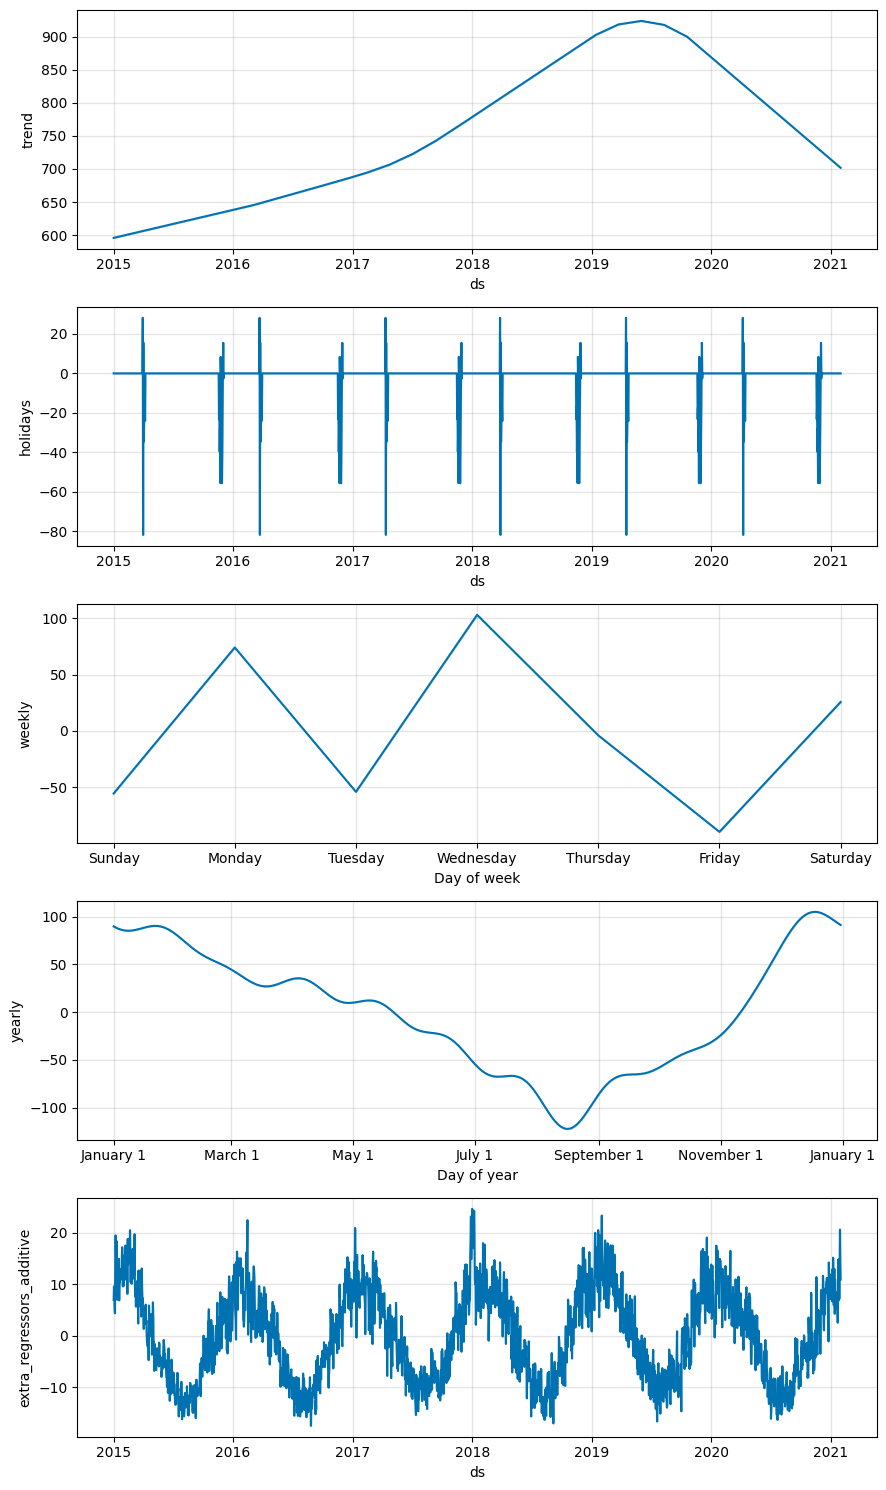

In [38]:
# Components 
m.plot_components(forecasting);

# Exporting the forecast

In [39]:
# Extracting the predictions


# our actual forecasting is yhat
# every single day for the last day
forecasting.yhat

# we just want the last 31 
predictions_prophet = forecasting.yhat[-len(future_df):].rename("prophet")
# ds : date stamps we had before. 
# let's write the index with ds so it is easier to understand the data
predictions_prophet.index = future_df["ds"]
predictions_prophet

ds
2021-01-01    724.831535
2021-01-02    837.381917
2021-01-03    755.440191
2021-01-04    881.617047
2021-01-05    751.556590
2021-01-06    913.967145
2021-01-07    802.104758
2021-01-08    722.322517
2021-01-09    832.117154
2021-01-10    746.469985
2021-01-11    880.496276
2021-01-12    754.844242
2021-01-13    903.220302
2021-01-14    803.165924
2021-01-15    712.779013
2021-01-16    829.385110
2021-01-17    749.428781
2021-01-18    879.058697
2021-01-19    747.874742
2021-01-20    904.622843
2021-01-21    800.536782
2021-01-22    708.812011
2021-01-23    830.132636
2021-01-24    753.970992
2021-01-25    874.712166
2021-01-26    752.083421
2021-01-27    901.683578
2021-01-28    801.094689
2021-01-29    719.579587
2021-01-30    826.236565
2021-01-31    740.401342
Name: prophet, dtype: float64

In [40]:
# Exporting 
predictions_prophet.to_csv("predictions_prophete_forecasting_product.csv")